In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import os, sys
import re
import json
import glob
import datetime
from collections import Counter
from sklearn import svm

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from wordcloud import WordCloud

In [3]:
# Add parent directory to path to import modules from src
rpath = os.path.abspath('../../week0_network_analysis_project/')
if rpath not in sys.path:
    sys.path.insert(0, rpath)

from src.loader import SlackDataLoader
import src.utils as utils

### Columns we can get from a slack message<br>

message_type, message_content, sender_id, time_sent, message_distribution, time_thread_start, reply_count, reply_user_count, time_thread_end, reply_users

From a single slack message, we can get <br>

1. The message<br>
2. Type (message, file, link, etc)<br>
3. The sender_id (assigned by slack)<br>
4. The time the message was sent<br>
5. The team (i don't know what that is now)<br>
6. The type of the message (broadcast message, inhouse, just messgae)<br>
7. The thread the message generated (from here we can go):<br>
    7.1 Text/content of the message<br>
    7.2 The thread time of the message<br>
    7.3 The thread count (reply count)<br>
    7.4 The number of user that reply the message (count of users that participated in the thread)<br>
    7.5 The time the last thread message was sent <br>
    7.6 The users that participated in the thread (their ids are stored as well)<br>

In [4]:
# # combine all json file in all-weeks8-9
# def slack_parser(path_channel):
#     """ parse slack data to extract useful informations from the json file
#         step of execution
#         1. Import the required modules
#         2. read all json file from the provided path
#         3. combine all json files in the provided path
#         4. extract all required informations from the slack data
#         5. convert to dataframe and merge all
#         6. reset the index and return dataframe
#     """

#     # specify path to get json files
#     combined = []
#     for json_file in glob.glob(f"{path_channel}*.json"):
#         with open(json_file, 'r', encoding="utf8") as slack_data:
#             combined.append(slack_data)

#     # loop through all json files and extract required informations
#     dflist = []
#     for slack_data in combined:

#         msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st, reply_users, \
#         reply_count, reply_users_count, tm_thread_end = [],[],[],[],[],[],[],[],[],[]

#         for row in slack_data:
#             if 'bot_id' in row.keys():
#                 continue
#             else:
#                 msg_type.append(row['type'])
#                 msg_content.append(row['text'])
#                 if 'user_profile' in row.keys(): sender_id.append(row['user_profile']['real_name'])
#                 else: sender_id.append('Not provided')
#                 time_msg.append(row['ts'])
#                 if 'blocks' in row.keys() and len(row['blocks'][0]['elements'][0]['elements']) != 0 :
#                      msg_dist.append(row['blocks'][0]['elements'][0]['elements'][0]['type'])
#                 else: msg_dist.append('reshared')
#                 if 'thread_ts' in row.keys():
#                     time_thread_st.append(row['thread_ts'])
#                 else:
#                     time_thread_st.append(0)
#                 if 'reply_users' in row.keys(): reply_users.append(",".join(row['reply_users'])) 
#                 else:    reply_users.append(0)
#                 if 'reply_count' in row.keys():
#                     reply_count.append(row['reply_count'])
#                     reply_users_count.append(row['reply_users_count'])
#                     tm_thread_end.append(row['latest_reply'])
#                 else:
#                     reply_count.append(0)
#                     reply_users_count.append(0)
#                     tm_thread_end.append(0)
#         data = zip(msg_type, msg_content, sender_id, time_msg, msg_dist, time_thread_st,
#          reply_count, reply_users_count, reply_users, tm_thread_end)
#         columns = ['msg_type', 'msg_content', 'sender_name', 'msg_sent_time', 'msg_dist_type',
#          'time_thread_start', 'reply_count', 'reply_users_count', 'reply_users', 'tm_thread_end']

#         df = pd.DataFrame(data=data, columns=columns)
#         df = df[df['sender_name'] != 'Not provided']
#         dflist.append(df)

#     dfall = pd.concat(dflist, ignore_index=True)
#     dfall['channel'] = path_channel.split('/')[-1].split('.')[0]        
#     dfall = dfall.reset_index(drop=True)
    
#     return dfall


# def parse_slack_reaction(path, channel):
#     """get reactions"""
#     dfall_reaction = pd.DataFrame()
#     combined = []
#     for json_file in glob.glob(f"{path}*.json"):
#         with open(json_file, 'r') as slack_data:
#             combined.append(slack_data)

#     reaction_name, reaction_count, reaction_users, msg, user_id = [], [], [], [], []

#     for k in combined:
#         slack_data = json.load(open(k.name, 'r', encoding="utf-8"))
        
#         for i_count, i in enumerate(slack_data):
#             if 'reactions' in i.keys():
#                 for j in range(len(i['reactions'])):
#                     msg.append(i['text'])
#                     user_id.append(i['user'])
#                     reaction_name.append(i['reactions'][j]['name'])
#                     reaction_count.append(i['reactions'][j]['count'])
#                     reaction_users.append(",".join(i['reactions'][j]['users']))
                
#     data_reaction = zip(reaction_name, reaction_count, reaction_users, msg, user_id)
#     columns_reaction = ['reaction_name', 'reaction_count', 'reaction_users_count', 'message', 'user_id']
#     df_reaction = pd.DataFrame(data=data_reaction, columns=columns_reaction)
#     df_reaction['channel'] = channel
#     return df_reaction

# def get_community_participation(path):
#     """ specify path to get json files"""
#     combined = []
#     comm_dict = {}
#     for json_file in glob.glob(f"{path}*.json"):
#         with open(json_file, 'r') as slack_data:
#             combined.append(slack_data)
#     # print(f"Total json files is {len(combined)}")
#     for i in combined:
#         a = json.load(open(i.name, 'r', encoding='utf-8'))

#         for msg in a:
#             if 'replies' in msg.keys():
#                 for i in msg['replies']:
#                     comm_dict[i['user']] = comm_dict.get(i['user'], 0)+1
#     return comm_dict

In [5]:
# def convert_2_timestamp(column, data):
#     """convert from unix time to readable timestamp
#         args: column: columns that needs to be converted to timestamp
#                 data: data that has the specified column
#     """
#     if column in data.columns.values:
#         timestamp_ = []
#         for time_unix in data[column]:
#             if time_unix == 0:
#                 timestamp_.append(0)
#             else:
#                 a = datetime.datetime.fromtimestamp(float(time_unix))
#                 timestamp_.append(a.strftime('%Y-%m-%d %H:%M:%S'))
#         return timestamp_
#     else: 
#         print(f"{column} not in data")

# def get_tagged_users(df):
#     """get all @ in the messages"""

#     return df['msg_content'].map(lambda x: re.findall(r'@U\w+', x))


    
# def map_userid_2_realname(user_profile: dict, comm_dict: dict, plot=False):
#     """
#     map slack_id to realnames
#     user_profile: a dictionary that contains users info such as real_names
#     comm_dict: a dictionary that contains slack_id and total_message sent by that slack_id
#     """
#     user_dict = {} # to store the id
#     real_name = [] # to store the real name
#     ac_comm_dict = {} # to store the mapping
#     count = 0
#     # collect all the real names
#     for i in range(len(user_profile['profile'])):
#         real_name.append(dict(user_profile['profile'])[i]['real_name'])

#     # loop the slack ids
#     for i in user_profile['id']:
#         user_dict[i] = real_name[count]
#         count += 1

#     # to store mapping
#     for i in comm_dict:
#         if i in user_dict:
#             ac_comm_dict[user_dict[i]] = comm_dict[i]

#     ac_comm_dict = pd.DataFrame(data= zip(ac_comm_dict.keys(), ac_comm_dict.values()),
#     columns=['LearnerName', '# of Msg sent in Threads']).sort_values(by='# of Msg sent in Threads', ascending=False)
    
#     if plot:
#         ac_comm_dict.plot.bar(figsize=(15, 7.5), x='LearnerName', y='# of Msg sent in Threads')
#         plt.title('Student based on Message sent in thread', size=20)
        
#     return ac_comm_dict

In [6]:
def get_top_20_user(data, channel='Random'):
    """get user with the highest number of message sent to any channel"""

    data['sender_name'].value_counts()[:20].plot.bar(figsize=(15, 7.5))
    plt.title(f'Top 20 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

    data['sender_name'].value_counts()[-10:].plot.bar(figsize=(15, 7.5))
    plt.title(f'Bottom 10 Message Senders in #{channel} channels', size=15, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=14);
    plt.xticks(size=12); plt.yticks(size=12);
    plt.show()

def draw_avg_reply_count(data, channel='Random'):
    """who commands many reply?"""

    data.groupby('sender_name')['reply_count'].mean().sort_values(ascending=False)[:20]\
        .plot(kind='bar', figsize=(15,7.5));
    plt.title(f'Average Number of reply count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_avg_reply_users_count(data, channel='Random'):
    """who commands many user reply?"""

    data.groupby('sender_name')['reply_users_count'].mean().sort_values(ascending=False)[:20].plot(kind='bar',
     figsize=(15,7.5));
    plt.title(f'Average Number of reply user count per Sender in #{channel}', size=20, fontweight='bold')
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

def draw_wordcloud(msg_content, week):    
    # word cloud visualization
    allWords = ' '.join([twts for twts in msg_content])
    wordCloud = WordCloud(background_color='#975429', width=500, height=300, random_state=21, max_words=500, mode='RGBA',
                            max_font_size=140, stopwords=stopwords.words('english')).generate(allWords)
    plt.figure(figsize=(15, 7.5))
    plt.imshow(wordCloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout()
    plt.title(f'WordCloud for {week}', size=30)
    plt.show()

def draw_user_reaction(data, channel='General'):
    data.groupby('sender_name')[['reply_count', 'reply_users_count']].sum()\
        .sort_values(by='reply_count',ascending=False)[:10].plot(kind='bar', figsize=(15, 7.5))
    plt.title(f'User with the most reaction in #{channel}', size=25);
    plt.xlabel("Sender Name", size=18); plt.ylabel("Frequency", size=18);
    plt.xticks(size=14); plt.yticks(size=14);
    plt.show()

## Insight Extraction

Below are some useful questions to answer. Feel free to explore to answer other interesting questions that may be of help to get insight about student's behaviour, need, and future performance 

In [7]:
# which user has the highest number of reply counts?
import pandas as pd
data_folder_path = "../../week0_network_analysis_project/data/anonymized/"
data_loader = SlackDataLoader(data_folder_path)
all_week_path =  "../../week0_network_analysis_project/data/anonymized/all-week1/"

ll_week_path = "../../week0_network_analysis_project/data/anonymized/all-week1/"
dfall_week = data_loader.slack_parser(all_week_path)
user_reply_counts = dfall_week.groupby('sender_name')['reply_count'].sum()
highest_reply_user = user_reply_counts.idxmax()
print(f"The user with the highest number of reply counts is: {highest_reply_user}")


Type of 'row': <class 'dict'>
Row data: {'client_msg_id': '2203614b-ffe8-4f86-9d51-e606e731bad6', 'type': 'message', 'text': 'check this site. it mighy help\n<https://www.tutorialspoint.com/python_data_science/python_data_aggregation.htm|https://www.tutorialspoint.com/python_data_science/python_data_aggregation.htm>', 'user': 'U03UKGSDGSG', 'ts': '1661238355.026149', 'blocks': [{'type': 'rich_text', 'block_id': 'leJG', 'elements': [{'type': 'rich_text_section', 'elements': [{'type': 'text', 'text': 'check this site. it mighy help\n'}, {'type': 'link', 'url': 'https://www.tutorialspoint.com/python_data_science/python_data_aggregation.htm', 'text': 'https://www.tutorialspoint.com/python_data_science/python_data_aggregation.htm'}]}]}], 'team': 'T03U4J8HMUG', 'user_team': 'T03U4J8HMUG', 'source_team': 'T03U4J8HMUG', 'user_profile': {'avatar_hash': 'd48c73f2f37d', 'image_72': 'https://avatars.slack-edge.com/2022-08-21/3992810751648_d48c73f2f37d608ae5b5_72.jpg', 'first_name': 'John', 'real_n

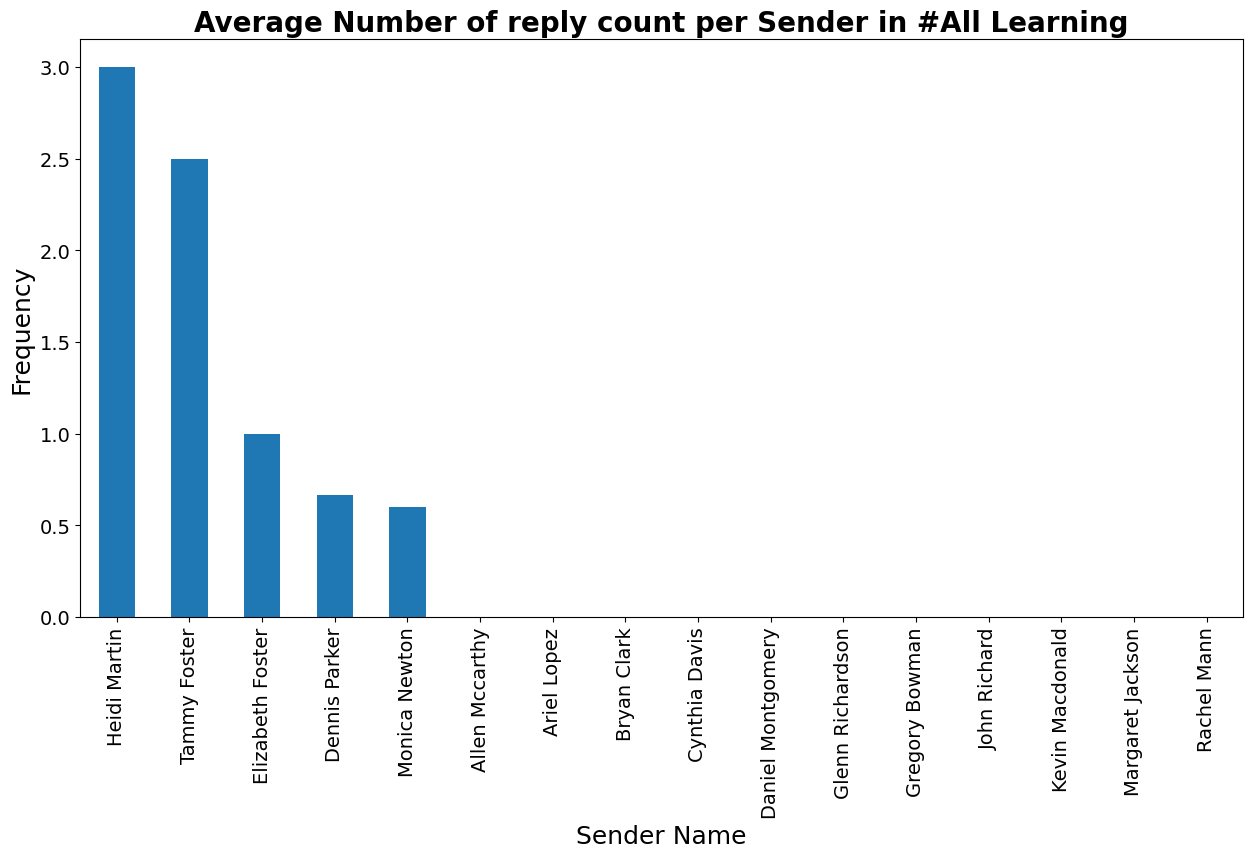

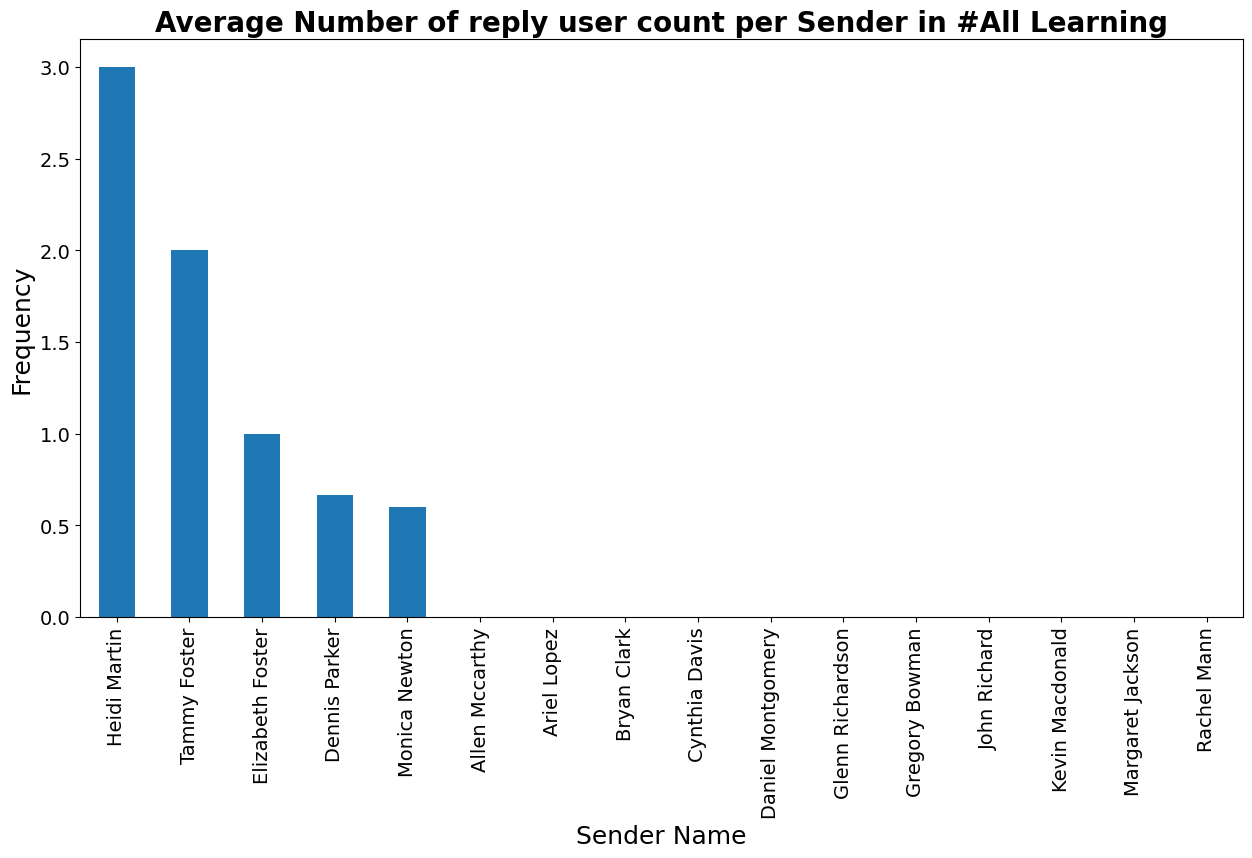

In [8]:
# Visualize reply counts per user per channel
draw_avg_reply_count(dfall_week, channel='All Learning')
draw_avg_reply_users_count(dfall_week, channel='All Learning')


Type of 'row': <class 'dict'>
Row data: {'client_msg_id': 'A30DE6AB-65D5-4846-8C35-20864F951B61', 'type': 'message', 'text': '<@u03u9ejr362> i can’t, i’m in a noisy place atm.', 'user': 'U03V785NLSU', 'ts': '1667809745.890659', 'blocks': [{'type': 'rich_text', 'block_id': 'E7eLx', 'elements': [{'type': 'rich_text_section', 'elements': [{'type': 'user', 'user_id': 'U03U9EJR362'}, {'type': 'text', 'text': ' i can’t, i’m in a noisy place atm.'}]}]}], 'team': 'T03U4J8HMUG', 'user_team': 'T03U4J8HMUG', 'source_team': 'T03U4J8HMUG', 'user_profile': {'avatar_hash': '48d5c88821e9', 'image_72': 'https://avatars.slack-edge.com/2022-08-21/3993277785968_48d5c88821e922581e17_72.jpg', 'first_name': 'Jason', 'real_name': 'Jason Burnett', 'display_name': 'Jason Burnett', 'team': 'T03U4J8HMUG', 'name': 'Jason', 'is_restricted': False, 'is_ultra_restricted': False}, 'thread_ts': '1667807598.812679', 'parent_user_id': 'U03U9EJR362', 'reactions': [{'name': '+1::skin-tone-3', 'users': ['U03U9EJR362'], 'cou

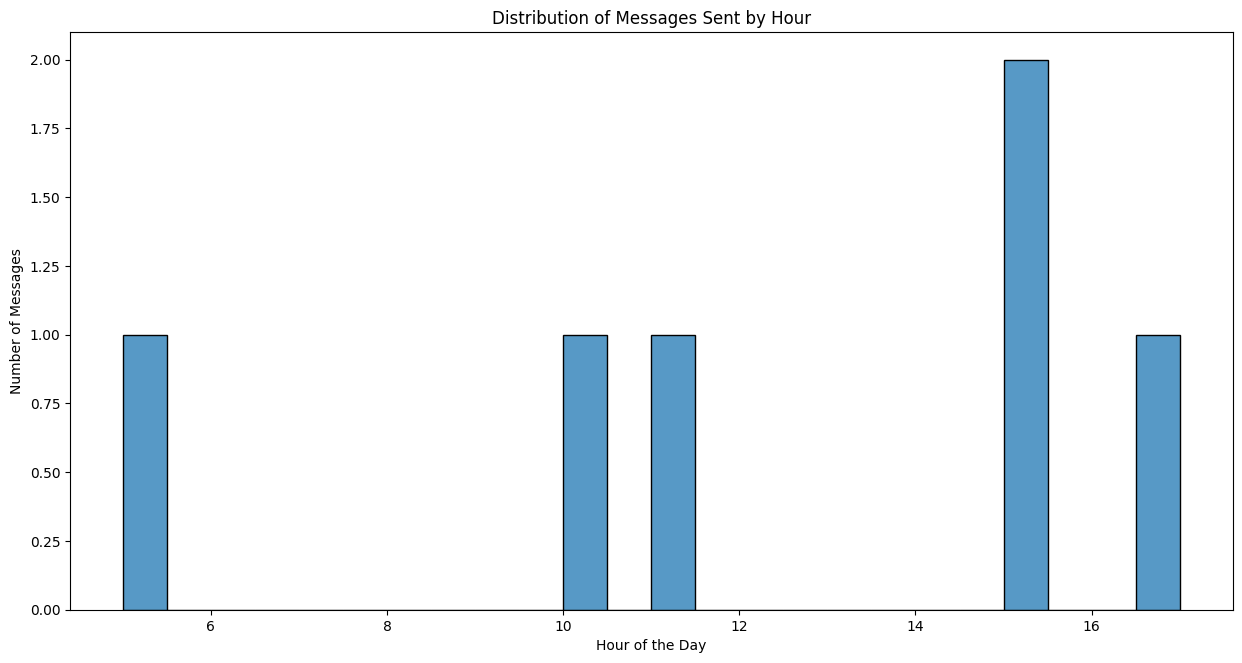

The most messages are sent during the hour: 15-16


In [9]:
# what is the time range of the day that most messages are sent?

# Convert Unix timestamp to readable timestamp
from src.utils import convert_2_timestamp
all_week_path = "../../week0_network_analysis_project/data/anonymized/week-11-group4/"
data_loader = SlackDataLoader(data_folder_path)
df = data_loader.slack_parser(all_week_path)
df['msg_sent_hour'] = convert_2_timestamp('msg_sent_time', df)
df['msg_sent_hour'] = pd.to_datetime(df['msg_sent_hour']).dt.hour

# Plotting the distribution of messages sent by hour
plt.figure(figsize=(15, 7.5))
sns.histplot(df['msg_sent_hour'], bins=24, kde=False)
plt.title('Distribution of Messages Sent by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.show()

# Calculate the most active hour
most_active_hour = df['msg_sent_hour'].value_counts().idxmax()

# Print the result
print(f"The most messages are sent during the hour: {most_active_hour}-{most_active_hour+1}")


In [10]:
# # what kind of messages are replied faster than others?
# from src.utils import convert_2_timestamp

# all_week_path = "../../week0_network_analysis_project/data/anonymized/week-11-group4/"
# df = data_loader.slack_parser(all_week_path)

# # Convert timestamps to readable format
# df['ts'] = convert_2_timestamp('ts', df)
# df['latest_reply'] = convert_2_timestamp('latest_reply', df)
# df['ts'] = df['replies'].apply(lambda x: [convert_2_timestamp('ts', pd.DataFrame(x)) for x in x])

# # Calculate reply time for each reply
# df['reply_time'] = df.apply(lambda row: (row['latest_reply'] - row['ts']).total_seconds(), axis=1)

# # Categorize messages based on your criteria (e.g., length of the message)
# fast_replies = df[df['reply_time'] < YOUR_THRESHOLD]['text']

# # Print or analyze the messages with fast replies
# print("Messages with fast replies:")
# print(fast_replies)

Type of 'row': <class 'dict'>
Row data: {'client_msg_id': 'A30DE6AB-65D5-4846-8C35-20864F951B61', 'type': 'message', 'text': '<@u03u9ejr362> i can’t, i’m in a noisy place atm.', 'user': 'U03V785NLSU', 'ts': '1667809745.890659', 'blocks': [{'type': 'rich_text', 'block_id': 'E7eLx', 'elements': [{'type': 'rich_text_section', 'elements': [{'type': 'user', 'user_id': 'U03U9EJR362'}, {'type': 'text', 'text': ' i can’t, i’m in a noisy place atm.'}]}]}], 'team': 'T03U4J8HMUG', 'user_team': 'T03U4J8HMUG', 'source_team': 'T03U4J8HMUG', 'user_profile': {'avatar_hash': '48d5c88821e9', 'image_72': 'https://avatars.slack-edge.com/2022-08-21/3993277785968_48d5c88821e922581e17_72.jpg', 'first_name': 'Jason', 'real_name': 'Jason Burnett', 'display_name': 'Jason Burnett', 'team': 'T03U4J8HMUG', 'name': 'Jason', 'is_restricted': False, 'is_ultra_restricted': False}, 'thread_ts': '1667807598.812679', 'parent_user_id': 'U03U9EJR362', 'reactions': [{'name': '+1::skin-tone-3', 'users': ['U03U9EJR362'], 'cou

KeyError: 'replies'

In [ ]:
# Relationship between # of messages and # of reactions
from src.utils import convert_2_timestamp
from src.loader import SlackDataLoader
all_week_path = "../../week0_network_analysis_project/data/anonymized/week-11-group4/"
data_loader = SlackDataLoader(data_folder_path)
df_messages = data_loader.slack_parser(all_week_path)
df_reactions = data_loader.parse_slack_reaction(all_week_path, channel='All-Learning') 

# Merge the dataframes on a common column, such as 'message'
merged_df = pd.merge(df_messages, df_reactions, left_on='msg_content', right_on='message', how='inner')


# Plotting the relationship between # of messages and # of reactions
plt.figure(figsize=(15, 7.5))
sns.scatterplot(x='reply_count', y='reaction_count', data=merged_df)
plt.title('Relationship between # of Messages and # of Reactions')
plt.xlabel('# of Messages')
plt.ylabel('# of Reactions')
plt.show()



In [ ]:
# Classify messages into different categories such as questions, answers, comments, etc.

In [ ]:
# # Which users got the most reactions?
# import matplotlib.pyplot as plt
# import pandas as pd
# from src.utils import convert_2_timestamp
# from src.loader import SlackDataLoader

# all_week_path = "../../week0_network_analysis_project/data/anonymized/"
# data_loader = SlackDataLoader(all_week_path)
# channel_name = "all-ideas"

# # Load reaction data
# df_reaction = data_loader.parse_slack_reaction(all_week_path, channel_name)

# # Ensure 'reaction_count' is treated as numeric
# df_reaction['reaction_count'] = pd.to_numeric(df_reaction['reaction_count'], errors='coerce')

# # Group by user_id and sum the reaction counts
# user_reaction_counts = df_reaction.groupby('user_id')['reaction_count'].sum()

# # Sort the users by the total reaction counts in descending order
# sorted_users = user_reaction_counts.sort_values(ascending=False)

# # Display the top users
# print(sorted_users.head())

# # Plot the top users
# top_users = sorted_users.head(10)  
# top_users.plot(kind='bar', figsize=(10, 6))
# plt.title('Top Users by Total Reaction Counts')
# plt.xlabel('User ID')
# plt.ylabel('Total Reaction Counts')
# plt.show()



In [ ]:
# # Model topics mentioned in the channel



In [ ]:
# What are the topics that got the most reactions?

### Harder questions to look into

In [ ]:
# Based on messages, reactions, references shared, and other relevant data such as classification of questions into techical question, comment, answer, aorder stu the python, statistics, and sql skill level of a user?

### Minimum Essential To Do: Task 1

In [ ]:
# Who are the top and bottom 10  users by:
    # Reply count? 
    # Mention? 
    # Message count? 
    # Reaction count?

import pandas as pd


# Top and bottom 10 users by Reply count
top_users_reply_count = df.groupby('sender_name')['reply_count'].sum().sort_values(ascending=False).head(10)
bottom_users_reply_count = df.groupby('sender_name')['reply_count'].sum().sort_values().head(10)

# Top and bottom 10 users by Mention count
mention_count = df['msg_content'].apply(lambda x: len(re.findall(r'@U\w+', x)))
top_users_mention_count = mention_count.groupby(df['sender_name']).sum().sort_values(ascending=False).head(10)
bottom_users_mention_count = mention_count.groupby(df['sender_name']).sum().sort_values().head(10)

# Top and bottom 10 users by Message count
top_users_message_count = df['sender_name'].value_counts().head(10)
bottom_users_message_count = df['sender_name'].value_counts().tail(10)

# Top and bottom 10 users by Reaction count
top_users_reaction_count = df.groupby('sender_name')['reply_users_count'].sum().sort_values(ascending=False).head(10)
bottom_users_reaction_count = df.groupby('sender_name')['reply_users_count'].sum().sort_values().head(10)

# Display the results
print("Top 10 Users by Reply Count:")
print(top_users_reply_count)
print("\nBottom 10 Users by Reply Count:")
print(bottom_users_reply_count)

print("\nTop 10 Users by Mention Count:")
print(top_users_mention_count)
print("\nBottom 10 Users by Mention Count:")
print(bottom_users_mention_count)

print("\nTop 10 Users by Message Count:")
print(top_users_message_count)
print("\nBottom 10 Users by Message Count:")
print(bottom_users_message_count)

print("\nTop 10 Users by Reaction Count:")
print(top_users_reaction_count)
print("\nBottom 10 Users by Reaction Count:")
print(bottom_users_reaction_count)


In [ ]:
# What are the top 10 messages by 
    # Replies?
    # Reactions?
    # Mentions?

import pandas as pd


# Top 10 messages by Replies
top_messages_by_replies = df.sort_values(by='reply_count', ascending=False).head(10)

# Top 10 messages by Reactions
top_messages_by_reactions = df.sort_values(by='reply_users_count', ascending=False).head(10)

# Top 10 messages by Mentions
top_messages_by_mentions = df[df['msg_content'].str.contains('@U\w+')].head(10)

# Display the results
print("Top 10 Messages by Replies:")
print(top_messages_by_replies[['sender_name', 'msg_content', 'reply_count']])

print("\nTop 10 Messages by Reactions:")
print(top_messages_by_reactions[['sender_name', 'msg_content', 'reply_users_count']])

print("\nTop 10 Messages by Mentions:")
print(top_messages_by_mentions[['sender_name', 'msg_content']])


In [ ]:
# Which channel appears at the right top corner when you plot a 2D scatter plot where x-axis is the number of messages in the channel, y-axis is the sum of number of replies and reactions, and the color representing channels?

import matplotlib.pyplot as plt
import seaborn as sns
from src.loader import SlackDataLoader
import pandas as pd
import glob

all_week_path = "../../week0_network_analysis_project/data/anonymized/week-11-group4/"
df = data_loader.slack_parser(all_week_path)
print(df.head())


if not df.empty:
    # Calculate the total activity (sum of messages, replies, and reactions) for each channel
    required_columns = ['channel', 'msg_content', 'reply_count', 'reply_users_count']
    missing_columns = [col for col in required_columns if col not in df.columns]

    if missing_columns:
        print(f"Error: The following required columns are missing in the DataFrame: {missing_columns}")
    else:
        # Proceed with the groupby operation
        channel_activity = df.groupby('channel').agg({
            'msg_content': 'count',
            'reply_count': 'sum',
            'reply_users_count': 'sum'
        }).reset_index()

        # Calculate the total activity score (sum of replies and reactions)
        channel_activity['total_activity'] = channel_activity['reply_count'] + channel_activity['reply_users_count']

        if not channel_activity.empty:
            # Find the channel with the highest activity
            most_active_channel = channel_activity.loc[channel_activity['total_activity'].idxmax()]
            print(f"The channel with the highest activity is: {most_active_channel['channel']}")

            # Plot a 2D scatter plot
            plt.figure(figsize=(12, 8))
            sns.scatterplot(data=channel_activity, x='msg_content', y='total_activity', hue='channel', palette='viridis')

            # Annotate the point at the top right corner
            top_right_channel = channel_activity.loc[channel_activity['msg_content'].idxmax()]
            plt.annotate(f"{top_right_channel['channel']}",
                        (top_right_channel['msg_content'], top_right_channel['total_activity']),
                        textcoords="offset points", xytext=(-10,0), ha='center')

            plt.title("2D Scatter Plot of Channel Activity")
            plt.xlabel("Number of Messages")
            plt.ylabel("Total Activity (Replies + Reactions)")
            plt.show()
        else:
            print("Error: The channel_activity DataFrame is empty.")
else:
    print("Error: The main DataFrame (df) is empty.")


In [ ]:
# What fraction of messages are replied within the first 5mins?


df['msg_sent_time'] = convert_2_timestamp('msg_sent_time', df)
df['tm_thread_end'] = convert_2_timestamp('tm_thread_end', df)

# Drop rows with None values (timestamps that couldn't be converted)
df = df.dropna(subset=['msg_sent_time', 'tm_thread_end'])

# Continue with the rest of your code

# Calculate the time difference between messages and their first reply
df['time_diff_first_reply'] = pd.to_datetime(df['tm_thread_end']) - pd.to_datetime(df['msg_sent_time'])

# Filter messages with a valid first reply and where the time difference is within 5 minutes
valid_replies_within_5mins = df[df['time_diff_first_reply'].notnull() & (df['time_diff_first_reply'] <= pd.Timedelta('5 minutes'))]

# Calculate the fraction of messages replied within the first 5 minutes
fraction_replied_within_5mins = len(valid_replies_within_5mins) / len(df)
print(f"The fraction of messages replied within the first 5 minutes is: {fraction_replied_within_5mins:.2%}")

# Convert time difference to minutes for better visualization
df['time_diff_first_reply_minutes'] = df['time_diff_first_reply'].dt.total_seconds() / 60.0

# Extract the time of day in 24hr format
df['time_of_day'] = pd.to_datetime(df['msg_sent_time']).dt.hour + pd.to_datetime(df['msg_sent_time']).dt.minute / 60.0

# Plot the 2D scatter plot
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='time_diff_first_reply_minutes', y='time_of_day', hue='channel', palette='viridis')

plt.title("2D Scatter Plot: Time Difference vs. Time of Day")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Time of Day (24hr format)")
plt.show()